**<h2>Code to extract data by polygon in Google Earth Engine**
**<h4>César Iván Álvarez**
**<h5>Geospatial Data Scientist**

**<h2>Installing, loading and credential of libraries<h2>**

In [2]:
!pip install rasterio cartopy geopandas matplotlib matplotlib-scalebar

**<h2>Import Libraries<h2>**

In [3]:
from google.colab import drive #Mount Google Drive in your colab
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
from cartopy.io.img_tiles import OSM
import os

In [5]:
# Define the output directory on Google Drive
output_dir = '/content/drive/My Drive/CesarIvan/ICARDA/04_IMAGES'
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it doesn't exist

In [33]:
# Download the shapefile from a reliable source on GitHub
!wget -q https://github.com/nvkelso/natural-earth-vector/raw/master/geojson/ne_110m_admin_0_countries.geojson -O ne_110m_admin_0_countries.geojson

# Verify if the geojson file was downloaded correctly
print("Downloaded files:")
!ls -l ne_110m_admin_0_countries.geojson

# Dictionary to map continents with their bounding boxes (minx, maxx, miny, maxy)
continent_bounds = {
    "Africa": [-20, 55, -35, 37],
    "Asia": [25, 180, -10, 55],
    "Europe": [-30, 50, 35, 75],
    "North America": [-170, -25, 10, 85],
    "South America": [-90, -30, -60, 15],
    "Oceania": [110, 180, -50, 10],
    "Antarctica": [-180, 180, -90, -60]
}


# Function to detect the continent for a given country
def detect_continent(country_name):
    # Simplified continent mapping (you can enhance this as needed)
    continent_map = {
        "Senegal": "Africa",
        "Brazil": "South America",
        "Ecuador": "South America",
        "United States": "North America",
        "India": "Asia",
        "Australia": "Oceania",
        "France": "Europe",
        "Germany": "Europe",
        # Add more country-to-continent mappings here if needed
    }
    return continent_map.get(country_name, "Africa")  # Default to Africa if not found

# Function to generate the map with zoom on the country and an OpenStreetMap background
def generate_map(country_name):
    # Load the country data from the downloaded geojson file
    geojson_path = 'ne_110m_admin_0_countries.geojson'

    if not os.path.exists(geojson_path):
        print(f"GeoJSON file not found at {geojson_path}")
        return

    world = gpd.read_file(geojson_path)
    country = world[world['NAME'] == country_name]

    if country.empty:
        print(f"Country '{country_name}' not found!")
        return

    # Detect the continent based on the country name
    continent_name = detect_continent(country_name)
    continent_extent = continent_bounds.get(continent_name, [-20, 55, -35, 37])  # Default to Africa

    # Create the figure and base map with OpenStreetMap
    fig = plt.figure(figsize=(10, 10), dpi=600)  # Increase DPI for better quality
    ax = plt.axes(projection=ccrs.PlateCarree())

    # OpenStreetMap background
    osm_tiles = OSM()
    ax.add_image(osm_tiles, 7)  # Zoom level 10 for better resolution

    # Set the map boundaries around the selected country
    minx, miny, maxx, maxy = country.total_bounds
    ax.set_extent([minx - 1, maxx + 1, miny - 1, maxy + 1], crs=ccrs.PlateCarree())

    # Draw the country with red borders and a thicker line
    country.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=2, transform=ccrs.PlateCarree())  # Thicker red border

    # Add map features
    ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='black')
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)

    # Add the geographic coordinate grid
    ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), linewidth=0.5, color='gray', alpha=0.5)

    # Add a scale bar
    from matplotlib_scalebar.scalebar import ScaleBar
    scalebar = ScaleBar(1, units='km', location='lower left')  # 1 degree ≈ 111 km
    ax.add_artist(scalebar)

    # Add the north arrow
    x, y, arrow_length = 0.1, 0.9, 0.1
    ax.annotate('N', xy=(x, y), xytext=(x, y - arrow_length),
                arrowprops=dict(facecolor='black', width=5, headwidth=15),
                ha='center', va='center', fontsize=12, xycoords=ax.transAxes)

    # Add the inset showing the location with zoom on the detected continent
    sub_ax = fig.add_axes([0.7, 0.6, 0.2, 0.2], projection=ccrs.PlateCarree())  # Adjusted position
    sub_ax.set_extent(continent_extent, crs=ccrs.PlateCarree())  # Zoom based on the continent
    sub_ax.add_feature(cfeature.COASTLINE)
    sub_ax.add_feature(cfeature.BORDERS, linestyle=':')
    sub_ax.add_feature(cfeature.LAND, facecolor='lightgray')
    sub_ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

    # Highlight the country in the inset
    country.plot(ax=sub_ax, edgecolor='red', facecolor='none', linewidth=2, transform=ccrs.PlateCarree())

    # Save the image as a JPEG file in Google Drive
    output_path = f'{output_dir}{country_name}_map.jpeg'
    plt.savefig(output_path, format='jpeg', dpi=300, bbox_inches='tight')  # Save with better resolution
    plt.show()

    print(f"Map saved to {output_path}")


Downloaded files:
-rw-r--r-- 1 root root 838726 Oct  6 23:26 ne_110m_admin_0_countries.geojson


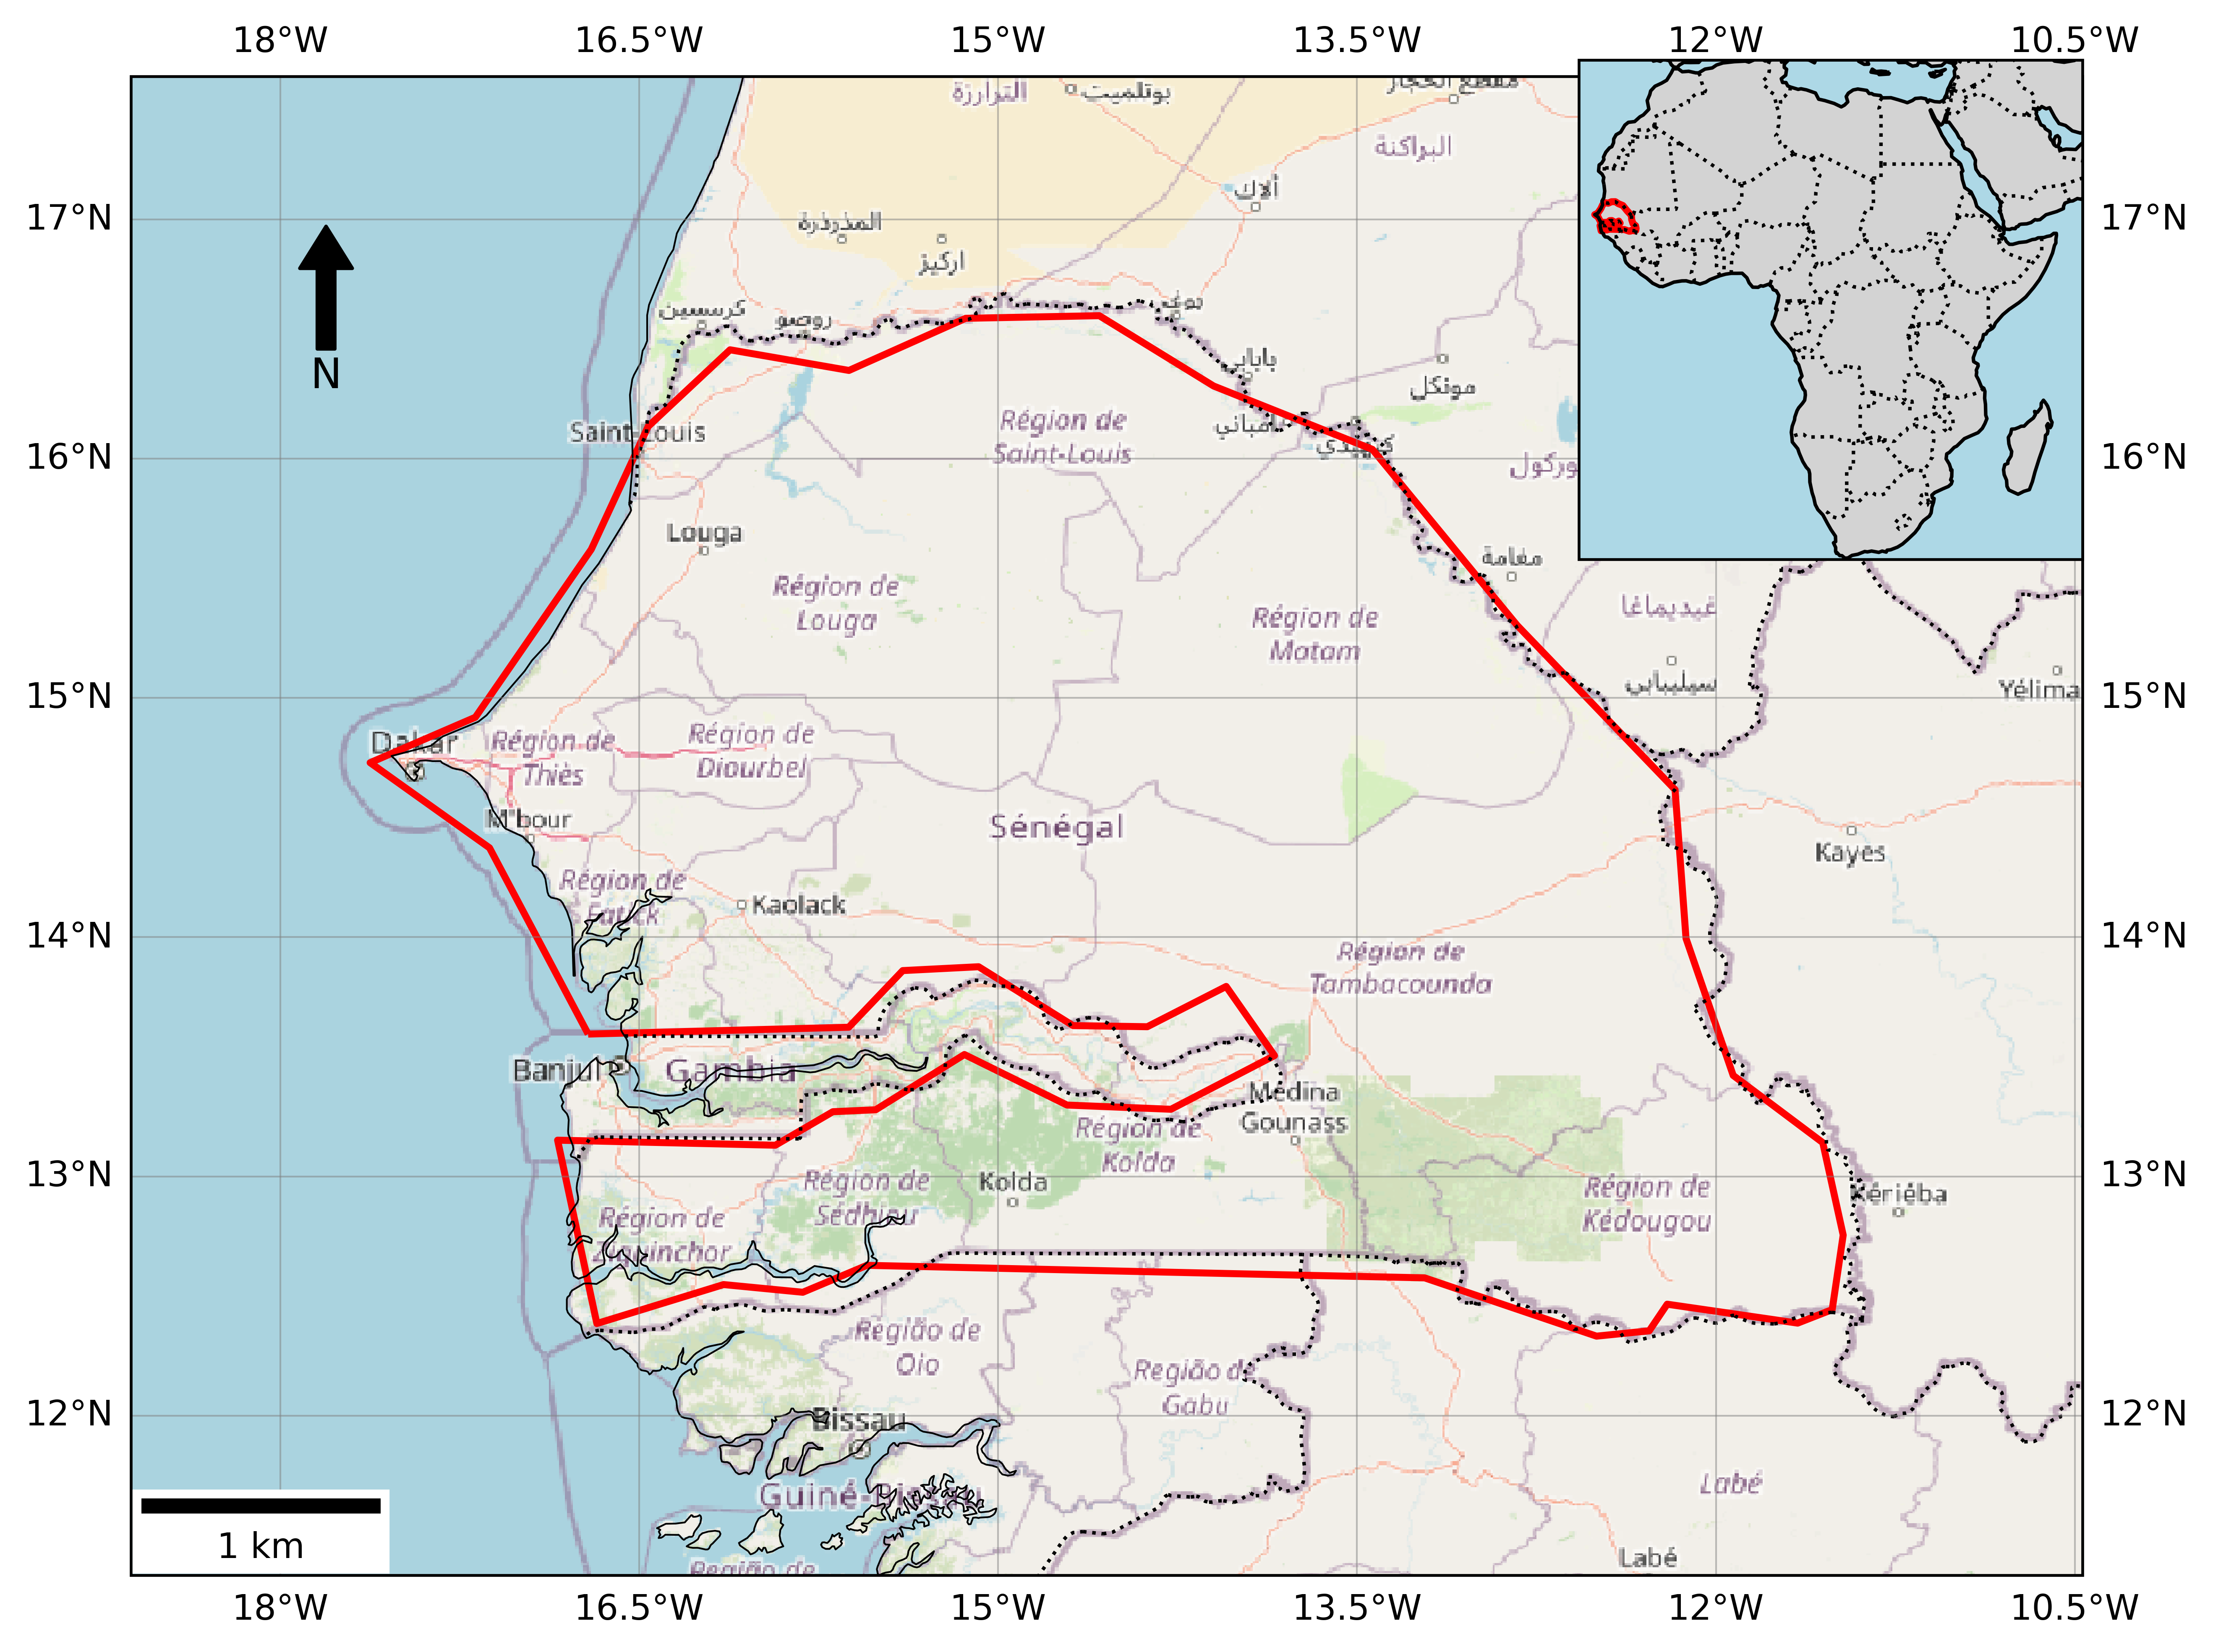

Map saved to /content/drive/My Drive/CesarIvan/ICARDA/Senegal_map.jpeg


In [34]:
# Change the country name as needed
country_name = 'Senegal'  # Change this to display another country
generate_map(country_name)